In [2]:
!pip install roboflow
from roboflow import Roboflow
rf = Roboflow(api_key="OE3Jg3u3F6BPO27NPQFe")
project = rf.workspace("takoyati").project("cigarette-vape-detection")
version = project.version(14)
dataset = version.download("yolov9")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling chardet-5.2.0:
      Successfully uninstalled chardet-5.2.0
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Cigarette-Vape-Detection-14 in yolov9:: 100%|██████████| 27712/27712 [00:03<00:00, 7444.69it/s]


In [3]:
import numpy as np
import os
import PIL
from PIL import Image
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

In [7]:
import os
import shutil

# 경로 설정
train_dir = '/content/Cigarette-Vape-Detection-14/valid'
labels_dir = os.path.join(train_dir, 'labels')
images_dir = os.path.join(train_dir, 'images')
vape_dir = os.path.join(train_dir, 'vape')
cigarette_dir = os.path.join(train_dir, 'cigarette')

# vape, cigarette 폴더 생성
os.makedirs(vape_dir, exist_ok=True)
os.makedirs(cigarette_dir, exist_ok=True)

# 파일 이동
for label_file in os.listdir(labels_dir):
    with open(os.path.join(labels_dir, label_file), 'r') as f:
        label = int(f.read().split()[0])
        image_name = os.path.splitext(label_file)[0]
        image_path = os.path.join(images_dir, image_name + '.jpg')

        if label == 0:
            dst_dir = vape_dir
        else:
            dst_dir = cigarette_dir

        shutil.copy(image_path, os.path.join(dst_dir, image_name + '.jpg'))

In [10]:
# ImageDataGenerator 설정
data_generator = ImageDataGenerator(rescale=1./255)

# train_generator 생성
train_generator = data_generator.flow_from_directory(
    '/content/Cigarette-Vape-Detection-14/train/rr',
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical',
)

# validation_generator 생성
validation_generator = data_generator.flow_from_directory(
    '/content/Cigarette-Vape-Detection-14/valid/rr',
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical',
)

# test_generator 생성
test_generator = data_generator.flow_from_directory(
    '/content/Cigarette-Vape-Detection-14/test/rr',
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical',
)

# 클래스 확인
print(train_generator.class_indices)
print(validation_generator.class_indices)
print(test_generator.class_indices)

Found 12114 images belonging to 2 classes.
Found 1159 images belonging to 2 classes.
Found 577 images belonging to 2 classes.
{'cigarette': 0, 'vape': 1}
{'cigarette': 0, 'vape': 1}
{'cigarette': 0, 'vape': 1}


In [32]:
# 클래스 인덱스 확인
class_indices = train_generator.class_indices
print(class_indices)

# 인덱스와 클래스 이름 매핑
index_to_class = {v: k for k, v in class_indices.items()}
print(index_to_class)

{'cigarette': 0, 'vape': 1}
{0: 'cigarette', 1: 'vape'}


# NASNet

In [28]:
model_name = 'NASNetLarge'
base_model= tf.keras.applications.NASNetLarge(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 새로운 레이어 추가
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
predictions = tf.keras.layers.Dense(2, activation='softmax')(x)
nasnet_model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# 이전 레이어들의 학습을 동결
for layer in base_model.layers:
    layer.trainable = False

343610240/343610240 [==============================] - 17s 0us/step


In [29]:
checkpoint_dir = '/content/Cigarette-Vape-Detection-14/checkpoint'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, model_name+'_model_epoch_{epoch:02d}_val_loss_{val_loss:.2f}.h5'),
    save_best_only=True,
    monitor='val_loss'
)

In [31]:
nasnet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 학습 및 체크포인트 저장
history_nasnet = nasnet_model.fit(
    train_generator,
    epochs=30,
    batch_size=16,
    callbacks=[checkpoint_callback],
    validation_data=validation_generator
)

Epoch 1/30
95/95 [==============================] - 64s 488ms/step - loss: 0.0766 - accuracy: 0.9713 - val_loss: 0.2622 - val_accuracy: 0.9025
Epoch 2/30
95/95 [==============================] - 40s 420ms/step - loss: 0.0302 - accuracy: 0.9913 - val_loss: 0.2465 - val_accuracy: 0.9051
Epoch 3/30
95/95 [==============================] - 41s 434ms/step - loss: 0.0190 - accuracy: 0.9942 - val_loss: 0.2369 - val_accuracy: 0.9206
Epoch 4/30
95/95 [==============================] - 42s 435ms/step - loss: 0.0089 - accuracy: 0.9976 - val_loss: 0.3240 - val_accuracy: 0.9094
Epoch 5/30
95/95 [==============================] - 41s 429ms/step - loss: 0.0045 - accuracy: 0.9992 - val_loss: 0.2899 - val_accuracy: 0.9154
Epoch 6/30
95/95 [==============================] - 42s 443ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.3197 - val_accuracy: 0.9198
Epoch 7/30
95/95 [==============================] - 41s 430ms/step - loss: 5.3440e-04 - accuracy: 1.0000 - val_loss: 0.3293 - val_accuracy: 0.

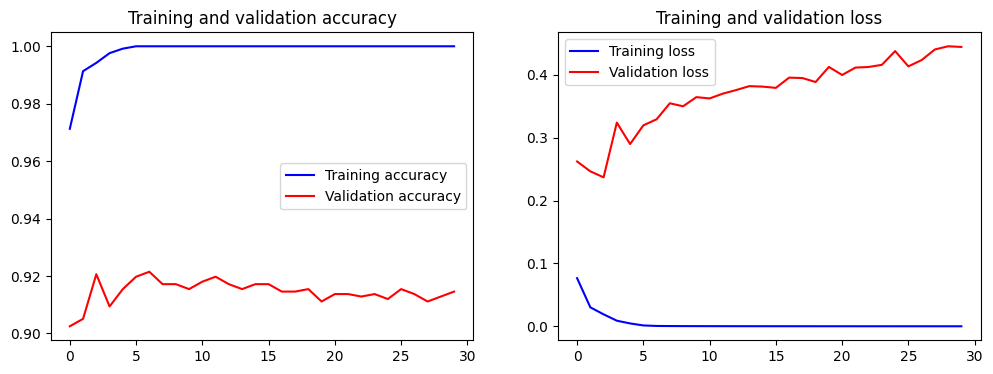

5/5 [==============================] - 2s 336ms/step - loss: 0.5646 - accuracy: 0.9220
Test Accuracy: 0.9220104217529297
5/5 [==============================] - 7s 359ms/step


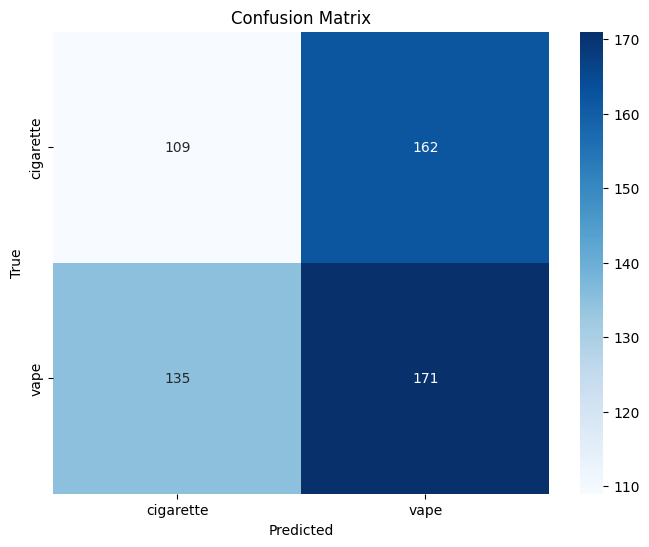

              precision    recall  f1-score   support

   cigarette       0.45      0.40      0.42       271
        vape       0.51      0.56      0.54       306

    accuracy                           0.49       577
   macro avg       0.48      0.48      0.48       577
weighted avg       0.48      0.49      0.48       577



In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 학습 결과 시각화
acc = history_nasnet.history['accuracy']
val_acc = history_nasnet.history['val_accuracy']
loss = history_nasnet.history['loss']
val_loss = history_nasnet.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 모델 평가
test_loss, test_acc = nasnet_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

# 예측 값 계산
Y_pred = nasnet_model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Confusion Matrix
conf_mat = confusion_matrix(test_generator.classes, y_pred)
class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(test_generator.classes, y_pred, target_names=class_names)
print(report)

10/10 [==============================] - 4s 358ms/step


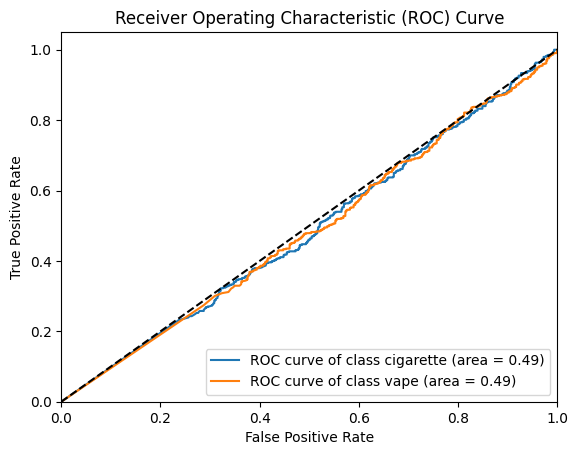

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 예측 확률 값 얻기
y_pred_prob = nasnet_model.predict(validation_generator)

# 레이블 원-핫 인코딩을 원래 레이블로 변환
y_val_labels = validation_generator.classes

# ROC 곡선 및 AUC 계산
fpr = {}
tpr = {}
roc_auc = {}

for i in range(train_generator.num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_labels == i, y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC 곡선 그리기
plt.figure()
for i in range(train_generator.num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {index_to_class[i]} (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()